In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta


In [2]:
tickerSymbol = 'MSFT' # for microsoft

tickerdata = yf.Ticker(tickerSymbol)

In [3]:
tick_df = tickerdata.history(interval = '1d', start = '2023-1-1', end = '2024-8-2')['Close']

In [4]:
tick_df = tick_df.asfreq(pd.infer_freq(tick_df.index))

Text(0.5, 1.0, 'MSFT Price data')

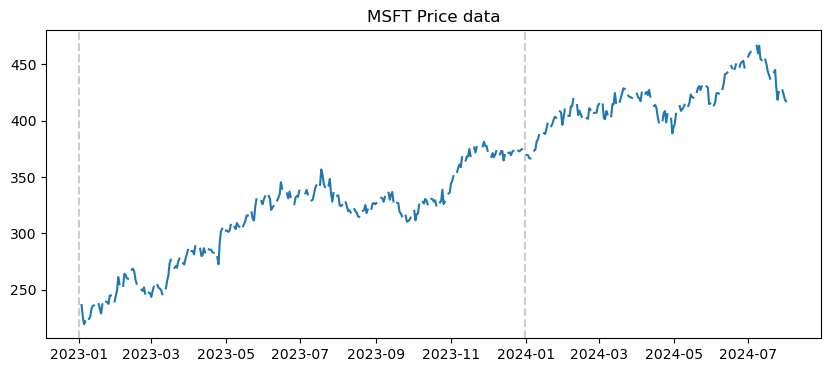

In [5]:
plt.figure(figsize = (10, 4))
plt.plot(tick_df)
for year in range(tick_df.index[0].year, tick_df.index[-1].year + 1):
    plt.axvline(datetime(year, 1, 1), color = 'k', linestyle = '--', alpha = 0.2)

plt.title(f'{tickerSymbol} Price data')

**NOTE: Some gaps in the trend, as the stock market is closed on Weekends and holidays. **

## Basic Buying protocol
### - buy if stock increases for b consecutive days

## Basic selling protocol
### - sell if stock decreases for s consecutive days (and we've made a profit)

In [6]:
def get_buy_selling_days(price_data, b, s):

    # get the percent change 
    pct_change = price_data.pct_change()[1:]

    #check the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()

    def selling_condition(sub_series):
        return (sub_series < 0).all()

    buying_days = pct_change.rolling(b).apply(buying_condition)

    selling_days = pct_change.rolling(s).apply(selling_condition)

    #return the dictionary 
    return {'buying days' : buying_days, 'potential selling days': selling_days}


In [7]:
info_dict = get_buy_selling_days(tick_df, 3, 3)

In [8]:
buying_days = info_dict['buying days']
selling_days = info_dict['potential selling days']

In [9]:
# creating a dataframe to store the information
df_stocks = pd.DataFrame(index = buying_days.index)

In [10]:
df_stocks['buying_days'] = (buying_days == 1)
df_stocks['potential_selling_days'] = (selling_days == 1) #because we still need to ensure whether we made a profit to ensure the condition 
#selling days

df_stocks['price'] = tick_df

In [11]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    '''
    checks whether we made a profit between a buying and a potential selling date
    '''

    pct_change = price_data.pct_change()[1:]

    sub_series = 1 + pct_change[buy_date : potential_sell_date]

    return sub_series.product() > 1

In [24]:
def get_investing_result(df_stocks, starting_funds, verbose = False): 
    price_data  = df_stocks.price

    # initially not holding any stock
    holding = False

    # initial variables
    current_funds = starting_funds
    current_share = 0
    last_buy_date = None

    # dictionary of buying and selling dates
    events_list = []

    # for each buying and potential selling day
    for date, data in df_stocks.iterrows(): #iterate over rows

        if (not holding) and data.buying_days:

            # calculate number of share you can buy
            num_shares_to_buy = int(current_funds/data.price)

            # increase the number of share
            current_share += num_shares_to_buy

            # decrease current funds
            current_funds -= num_shares_to_buy * data.price

            # set last buy date
            last_buy_date = date

            events_list.append(('b', date))

            # and now we are holding
            holding = True

            if verbose:
                print(f'Bought {num_shares_to_buy} on {date.strftime("%Y-%m-%d")} at price {data.price}')
                print('----------------------------------------------')
                
        elif holding and data.potential_selling_days:

            # check the profit condition for selling
            if check_cumulative_percent_change(price_data, last_buy_date, date):

                #add selling money to our current funds
                current_funds += current_share * data.price

                if verbose:
                     print(f'Sold {current_share} on {date.strftime("%Y-%m-%d")} at price {data.price}')
                     print('----------------------------------------------')
                    
                holding = False
                current_share = 0

                events_list.append(('s', date))

    # get the stock price at end of time span
    final_stock_price = price_data[-1]

    # final total value of all asset
    final_value = current_funds + final_stock_price * current_share

    # return percent change in value 
    return round((final_value - starting_funds)/ starting_funds , 2), events_list

In [25]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 42 on 2023-01-11 at price 232.84646606445312
----------------------------------------------
Sold 42 on 2023-02-10 at price 259.8376159667969
----------------------------------------------
Bought 42 on 2023-03-15 at price 262.80517578125
----------------------------------------------
Sold 42 on 2023-04-05 at price 281.51751708984375
----------------------------------------------
Bought 39 on 2023-04-28 at price 304.2100524902344
----------------------------------------------
Sold 39 on 2023-07-21 at price 341.1016540527344
----------------------------------------------
Bought 41 on 2023-08-23 at price 325.1488037109375
----------------------------------------------
Sold 41 on 2024-01-04 at price 366.5995788574219
----------------------------------------------
Bought 39 on 2024-01-10 at price 381.37554931640625
----------------------------------------------
Sold 39 on 2024-03-06 at price 401.36602783203125
----------------------------------------------
Bought 37 on 2024-03-20 at p

In [14]:
percent_change

0.69

In [15]:
events_list

[('b', Timestamp('2023-01-11 00:00:00-0500', tz='America/New_York')),
 ('s', Timestamp('2023-02-10 00:00:00-0500', tz='America/New_York')),
 ('b', Timestamp('2023-03-15 00:00:00-0400', tz='America/New_York')),
 ('s', Timestamp('2023-04-05 00:00:00-0400', tz='America/New_York')),
 ('b', Timestamp('2023-04-28 00:00:00-0400', tz='America/New_York')),
 ('s', Timestamp('2023-07-21 00:00:00-0400', tz='America/New_York')),
 ('b', Timestamp('2023-08-23 00:00:00-0400', tz='America/New_York')),
 ('s', Timestamp('2024-01-04 00:00:00-0500', tz='America/New_York')),
 ('b', Timestamp('2024-01-10 00:00:00-0500', tz='America/New_York')),
 ('s', Timestamp('2024-03-06 00:00:00-0500', tz='America/New_York')),
 ('b', Timestamp('2024-03-20 00:00:00-0400', tz='America/New_York')),
 ('s', Timestamp('2024-03-27 00:00:00-0400', tz='America/New_York')),
 ('b', Timestamp('2024-04-24 00:00:00-0400', tz='America/New_York')),
 ('s', Timestamp('2024-07-18 00:00:00-0400', tz='America/New_York'))]

(208.0, 490.0)

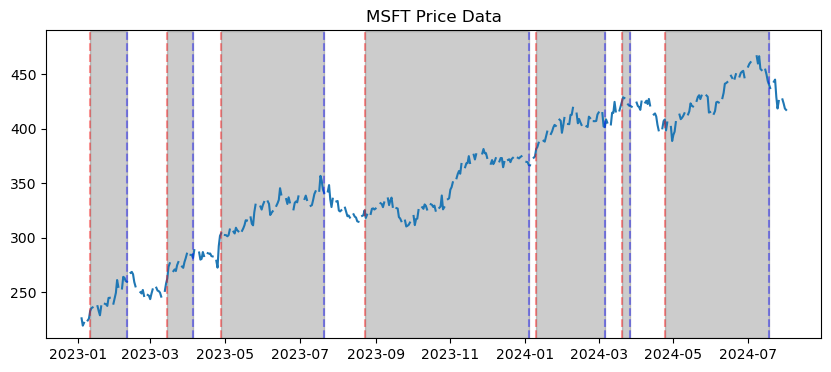

In [29]:
plt.figure(figsize = (10,4))
plt.plot(df_stocks['price'])

y_lims = (int(df_stocks['price'].min() * 0.95) , int(df_stocks['price'].max() * 1.05)) 
shaded_ylims = int(df_stocks['price'].min() * 0.1), int(df_stocks['price'].max() * 1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'

    plt.axvline(event[1], color = color, linestyle = '--', alpha = 0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_ylims), 
                          event[1], events_list[idx - 1][1], color = 'k', alpha = 0.2)

plt.title(f'{tickerSymbol} Price Data')
plt.ylim(*y_lims)


In [17]:
shaded_ylims

(21, 701)